In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/OptiML/repo/OptML-project

/content/drive/MyDrive/OptiML/repo/OptML-project


## Global Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, recall_score, f1_score
from Functions.implementations import *
from Functions.visualization import *
from sklearn.metrics import f1_score

## Load Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
train_loader,valid_loader, test_loader = get_data_loaders()

Train and evaluate a simple model to test if everything works.

# Adam :

In [ ]:
import os

#only for google Colab :

# Set a path in your Google Drive
csv_path = "/content/drive/MyDrive/OptiML/Results/Adam_VGG.csv"
save_path = "/content/drive/MyDrive/OptiML/Results/Adam_VGG"
# For local machine, set the path to your desired location
#save_path = os.getcwd() + "/Results/SGD"
#csv_path = save_path + "/sgd_gridsearch_results.csv"


epochs = 100
eval_interval = 10

# Create the CSV with headers if it doesn't exist
if not os.path.exists(csv_path):
    columns = ["learning_rate", "momentum"] +  [f"epoch_{i}" for i in range(epochs//eval_interval, epochs + 1, eval_interval)] + ["Test"]
    pd.DataFrame(columns=columns).to_csv(csv_path, index=False)

set_seed(42) # Set a random seed for reproducibility

In [ ]:
from itertools import product


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader,valid_loader, test_loader = get_data_loaders(batch_size=128)

results_grid = {}

learning_rates = [1e-4, 5e-5]
beta_1s = [0.9]
beta_2s = [0.999, 0.98]

# Iterate over all combinations of lr and momentum
for lr, beta_1, beta_2 in product(learning_rates, beta_1s, beta_2s):
    scores, model = train_and_return_evaluation_Adam(
        VGGLike,
        lr=lr,
        beta_1=beta_1,
        beta_2=beta_2,
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        device=device,
        epochs=epochs,
        eval_interval=eval_interval
    )
    results_grid[(lr, beta_1, beta_2)] = scores

    # Extract F1 scores only, for CSV export
    f1_scores = [f1 for (_, _, _, f1) in scores]

    row = [lr, beta_1, beta_2] + f1_scores

    # Append to CSV
    df_row = pd.DataFrame([row])
    df_row.to_csv(csv_path, mode='a', header=False, index=False)

    # Save the model
    torch.save(model.state_dict(), save_path + f"/VGG_lr_{lr}_beta1_{beta_1}_beta2_{beta_2}.pth")

# Visualization

In [3]:
df = pd.read_csv("Results/Adam/Adam_resnet.csv")
data = df[df['learning_rate'].isin([1.e-03, 5.e-04, 1.e-04, 5.e-05])].reset_index(drop=True)

In [ ]:
df.groupby(['learning_rate', 'beta_1', 'beta_2']).mean()

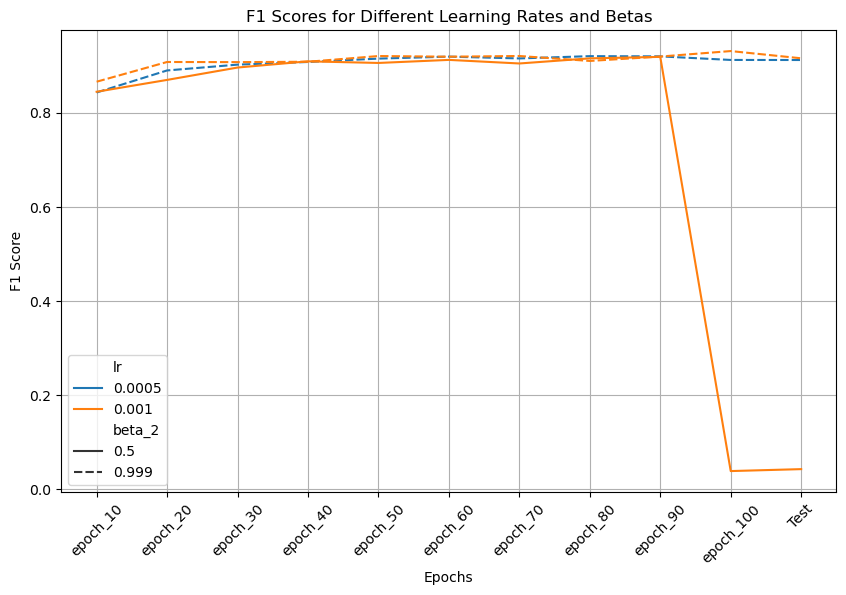

In [5]:
data_ = reshape_data_for_sns_plot(data)
plot_F1_Adam_sns(data_, hue="lr", style="beta_2")

In [29]:
from scipy.stats import ttest_ind

# Perform t-test for learning rates
ttest_ind(df[df['beta_2'] != 0.5]['Test'], df[df['beta_2'] == 0.5]['Test'])[1]

np.float64(0.43591449586727005)

Significant difference between:
- lr = 0.001 and lr = 0.0005

No significant difference between 
- beta_1 = 0.9 and beta_1 = 0.8
- all combination of values for beta_2